# Xgboost Classifier

<img src="https://www.kdnuggets.com/wp-content/uploads/xgboost-tianqi-chen.jpg">

<p>Boosting is a sequential technique which works on the principle of an ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. Note that a weak learner is one which is slightly better than random guessing. For example, a decision tree whose predictions are slightly better than 50%.
</p>
<p>Here we are going to implement Xgboost Classifier using Telecom Churn Dataset.</p>

In [1]:
print()
print(format('Recipe for Data Science Competition - DSC_Recipe_7','*^65'))
print(format('Classification with OpenML telco Churn dataset using xgboost and Grid Search Cross Valodation', '*^95'))    
print(format('Package: scikit-learn ','*^65'))            
print(format('Model: XGBoost Model','*^65'))            
print(format('DataSet: OpenML telco Churn Dataset', '*^65'))    
print(format('Model selection: using Grid Search Cross Validation (GSCV)', '*^65')) 


*******Recipe for Data Science Competition - DSC_Recipe_7********
*Classification with OpenML telco Churn dataset using xgboost and Grid Search Cross Valodation*
*********************Package: scikit-learn **********************
**********************Model: XGBoost Model***********************
***************DataSet: OpenML telco Churn Dataset***************
***Model selection: using Grid Search Cross Validation (GSCV)****


## 0. Loading required libraries

In [2]:
import time
import pandas as pd
import pickle as pk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder    
start_time = time.time()

In [3]:
# declare contants
kfold = 10

## 1. Helper modules for Descriptive Statistics

In [4]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [5]:
def get_top_abs_correlations(df, n=5): 
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [7]:
def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j), 
                X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],
                columns=['pairs','corr'])
    print(df.sort_values(by='corr',ascending=False))
    print()

In [7]:
# Helper module for Label Encoding for Categorical Features
def dummyEncode(df):
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

## 2. Loading dataset

In [8]:
def load_dataset(filename):
        
    dataset = pd.read_csv(filename, sep = ',')
        
    print(dataset.shape);    print(dataset.head(5));    print(dataset.columns);
    print(dataset.dtypes)
        
    feature_names = ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 
    'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
    'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
    'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code']
        
    target = 'Churn'
        
    dataset = dummyEncode(dataset[['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 
    'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
    'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
    'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code', 'Churn']])
        
    return feature_names, target, dataset

## 3. Find missing values in dataset if exists

In [9]:
    def find_miising_value(feature_names, target, dataset):
        
        print()
        print('#---------------------------------------------------------------')
        print('Check for Mising Value or NaN Value in the Dataset')
        print('#---------------------------------------------------------------')
        # Method - 1
        # Count Number of Missing Value on Each Column    
        print('\nCount Number of Missing Value on Each Column: ')        
        print(dataset.isnull().sum(axis=0))

        # Method - 2
        # Check if there are any missing values in Dataset
        feature_count = dataset.columns[dataset.isnull().sum() != 0].size
        print()
        print("Total Features with missing Values = " + str(feature_count))

        if (feature_count):
            print()
            print("Features with NaN => {}".format(list(dataset.columns[dataset.isnull().sum() != 0])))
            print('Count Number of Missing Value on Each Column: ')        
            print(dataset[dataset.columns[dataset.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False))

        print()
        print('#---------------------------------------------------------------')
        print('Check and Remove constant columns in the Dataset')
        print('#---------------------------------------------------------------')
        colsToRemove = []
        for col in dataset.columns:
            if col not in ['Churn']:
                if dataset[col].std() == 0: 
                    colsToRemove.append(col)
        print()
        print("Removed `{}` Constant Columns: ".format(len(colsToRemove)))
        print(colsToRemove)
        # remove constant columns in the Dataset
        dataset.drop(colsToRemove, axis=1, inplace=True)

        print()
        print('#---------------------------------------------------------------')
        print('Check and Remove Duplicate Columns in the Dataset')
        print('#---------------------------------------------------------------')
        print()
        print(dataset.columns); print(dataset.head(5))
        print('\nDuplicate Columns in the Dataset: \n', dataset.columns.duplicated())        
        dataset = dataset.loc[:, ~dataset.columns.duplicated()]
        print()
        print(dataset.columns); print(dataset.head(5))
        
        print()
        print('#---------------------------------------------------------------')
        print('Check and Drop Sparse Data/Columns in the Dataset')
        print('#---------------------------------------------------------------')
        flist = [x for x in dataset.columns if not x in ['Class', 'Class']]
        print(); print(flist)
        for f in flist:
            if len(np.unique(dataset[f])) < 2:
                print('Feature contains Sparse Data: ', f)
                dataset.drop(f, axis=1, inplace=True)
        print()
        print(dataset.columns); print(dataset.head(5))
        
        # --------------------------------------------------
        # Missing Values treatment in the DataSet (if any)
        # --------------------------------------------------    

        # Filling NULL values according to their dataTypes
        # Group Dataset according to different dataTypes
        gd = dataset.columns.to_series().groupby(dataset.dtypes).groups
        print('\nGroup Columns according to their dataTypes: \n', gd)  
        colNames = dataset.columns.values.tolist()
        for colName in colNames:
            if dataset[colName].dtypes == 'int64':
                dataset[colName] = dataset[colName].fillna(0)
            if dataset[colName].dtypes == 'float64':
                dataset[colName] = dataset[colName].fillna(0.0) 
            if dataset[colName].dtypes == 'object':
                dataset[colName] = dataset[colName].fillna('Unknown')    

        ## Count Number of Missing Value on Each Column    
        print('\nCount Number of Missing Value on Each Column: ')        
        print(dataset.isnull().sum(axis=0))


        # Check if there are any missing values in Dataset
        feature_count = dataset.columns[dataset.isnull().sum() != 0].size
        print()
        print("Total Features with missing Values = " + str(feature_count))
        
        return(dataset)

## 4. Descriptive statistics and correlation matrix

In [10]:
    def data_descriptiveStats(feature_names, target, dataset):
        # Count Number of Missing Value on Each Column    
        print(); print('Count Number of Missing Value on Each Column: ')        
        print(); print(dataset[feature_names].isnull().sum(axis=0))
        print(); print(dataset[target].isnull().sum(axis=0))    
    
        # Get Information on the feature variables
        print(); print('Get Information on the feature variables: ')            
        print(); print(dataset[feature_names].info())
        print(); print(dataset[feature_names].describe())
    
        # correlation
        pd.set_option('precision', 2)
        print(); print(dataset[feature_names].corr())    
    
        # Ranking of Correlation Coefficients among Variable Pairs
        print(); print("Ranking of Correlation Coefficients:")    
        corrank(dataset[feature_names])

        # Print Highly Correlated Variables
        print(); print("Highly correlated variables (Absolute Correlations):")
        print(); print(get_top_abs_correlations(dataset[feature_names], 8))
    
        # Get Information on the target    
        print(); print(dataset[target].describe())    
        print(); print(dataset.groupby(target).size())    

## 5. Data visualisation and correlation graph

In [11]:
    def data_visualization(feature_names, target, dataset):
        # BOX plots USING box and whisker plots
        i = 1
        print(); print('BOX plot of each numerical features')
        plt.figure(figsize=(11,9))     
        for col in feature_names:
            plt.subplot(5,4,i)
            plt.axis('on')
            plt.tick_params(axis='both', left=True, top=False, right=False, bottom=True, 
                            labelleft=False, labeltop=False, labelright=False, labelbottom=False)
            dataset[col].plot(kind='box', subplots=True, sharex=False, sharey=False)
            i += 1
        plt.show()    
    
        # USING histograms
        j = 1
        print(); print('Histogram of each Numerical Feature')
        plt.figure(figsize=(11,9))     
        for col in feature_names:
            plt.subplot(5,4,j)
            plt.axis('on')
            plt.tick_params(axis='both', left=True, top=False, right=False, bottom=False, 
                            labelleft=False, labeltop=False, labelright=False, labelbottom=False)
            dataset[col].hist()
            j += 1
        plt.show()

        # correlation matrix
        print(); print('Correlation Matrix of All Numerical Features')   
        fig = plt.figure(figsize=(11,9))
        ax = fig.add_subplot(111)
        cax = ax.matshow(dataset[feature_names].corr(), vmin=-1, vmax=1, interpolation='none')
        fig.colorbar(cax)
        ticks = np.arange(0,19,1)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        plt.show()

        # Correlation Plot using seaborn
        print(); print("Correlation plot of Numerical features")
        # Compute the correlation matrix
        corr = dataset[feature_names].corr()
        print(corr)
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin= -1.0, center=0, square=True, 
                    linewidths=.5, cbar_kws={"shrink": .5})
        plt.show()    
    
        # Pie chart for Categorical Variables
        print(); print('PIE Chart of for Target: ')
        plt.figure(figsize=(11,9)) 
        i = 1
        for colName in [target]:
            labels = []; sizes = [];
            df = dataset.groupby(colName).size()
            for key in df.keys():
                labels.append(key)
                sizes.append(df[key])
            # Plot PIE Chart with %
            plt.subplot(2,2,i)
            plt.axis('on')
            plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                            labelleft=True, labeltop=True, labelright=False, labelbottom=False)        
            plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
            plt.axis('equal')
            i += 1; plt.savefig('Piefig.pdf', format='pdf')
        plt.show()  

## 6. Data split to train and test datasets

In [12]:
    def data_split(feature_names, target, dataset):
        # Data Transform - Split train : test datasets
        X_train, X_test, y_train, y_test = train_test_split(dataset.loc[:, feature_names], 
                                                            dataset.loc[:, target], test_size=0.33)
        return X_train, X_test, y_train, y_test

In [13]:
    def training_model(X_train, y_train):
        model = xgboost.XGBClassifier(objective = 'binary:logistic')
        
        parameters = {'max_depth'     : [6,8,10],
                      'gamma'         : [0.2,0.5,0.6],
                      'learning_rate' : [0.01, 0.05, 0.1],
                      'n_estimators'  : [100, 500, 1000]
                      # Add more ... ... ... 
                      }
        grid = GridSearchCV(estimator=model, param_grid = parameters, cv = kfold, 
                            verbose = 1, n_jobs = -1, refit = True)
        grid.fit(X_train, y_train)

        # Results from Grid Search
        print("\n========================================================")
        print(" Results from Grid Search " )
        print("========================================================")    
        print("\n The best estimator across ALL searched params:\n",
              grid.best_estimator_)
        print("\n The best score across ALL searched params:\n",
              grid.best_score_)
        print("\n The best parameters across ALL searched params:\n",
              grid.best_params_)
        print("\n ========================================================")

        return(grid.best_estimator_)

In [14]:
    def cross_validatin_and_fitting(model, X_train, y_train):
        cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy', 
                                 n_jobs = -1, verbose = 1)
        # Cross Validation Results
        print()
        print("Cross Validation results: ", cv_results)
        prt_string = "CV Mean Accuracy: %f (Std: %f)"% (cv_results.mean(), cv_results.std())
        print(prt_string)
        
        # Final fitting of the Model
        model.fit(X_train, y_train)
        
        print(); print('========================================================')
        print(); print(model.get_params(deep = True))
        print(); print('========================================================')        
        
        return model

In [15]:
    def evaluate_model(model, X_test, y_test):
        # Evaluate the skill of the Trained model
        pred_Class          = model.predict(X_test)
        pred_proba          = model.predict_proba(X_test)
        acc                 = accuracy_score(y_test, pred_Class)
        classReport         = classification_report(y_test, pred_Class)
        confMatrix          = confusion_matrix(y_test, pred_Class) 
        kappa_score         = cohen_kappa_score(y_test, pred_Class)         
        
        print(); print('Evaluation of the trained model: ')
        print(); print('Accuracy : ', acc)
        print(); print('Kappa Score : ', kappa_score)
        print(); print('Confusion Matrix :\n', confMatrix)
        print(); print('Classification Report :\n',classReport)

        pred_proba = model.predict_proba(X_test)
        
        # Add more plots here using scikit-plot
        # ROC curves
        skplt.metrics.plot_roc(y_test,pred_proba,figsize=(8,6)); plt.show()

        # Confusion matrix
        skplt.metrics.plot_confusion_matrix(y_test,pred_Class,figsize=(6,6)); plt.show()        
        
        # precision recall curve
        skplt.metrics.plot_precision_recall(y_test, pred_proba, 
                title='Precision-Recall Curve', plot_micro=True, 
                classes_to_plot=None, ax=None, figsize=(9,6), 
                cmap='nipy_spectral', title_fontsize='large', 
                text_fontsize='medium'); plt.show()
        
        # Add more ... ... ...
        
        return model

In [17]:
    def featureRank_Analysis(model, dataset, cols):
        print()
        print("Feature Importance/Rank Analysis: ")
        X = dataset.loc[:, cols]; X_cols = X.columns.values
    
        features_imp = model.feature_importances_    
    
        indices = np.argsort(features_imp)[::-1]
        df = {}
        for f in range(X.shape[1]):
            print("%d. feature %d %s (%f)" % (f + 1, indices[f], X_cols[indices[f]], 
                                              features_imp[indices[f]]))
            df[f] = [f + 1, indices[f], X_cols[indices[f]], features_imp[indices[f]]]

        df1 = pd.DataFrame.from_dict(df, orient = 'index')
        df1.columns = ['feature_Rank', 'feature_Index', 'feature_Name', 'feature_importance']
        df1.to_csv("FeatureImportanceRank.csv", index = False)

        # this creates a figure 5 inch wide, 3 inch high
        plt.figure(figsize=(5,3)) 
        plt.barh(df1['feature_Rank'], df1['feature_importance'], tick_label = df1['feature_Name'])
        plt.savefig('Featurefig.pdf', format='pdf')
        plt.show()   

        skplt.estimators.plot_feature_importances(model, feature_names=cols,
                                                  x_tick_rotation = 45, figsize=(5,3))
        plt.show()
        # plot feature importance
        xgboost.plot_importance(model); plt.show()

## 7. Make Prediction

In [18]:
    def save_model(model):
        with open('DSC_Recipe_7_model.pickle', 'wb') as f: 
            pk.dump(model, f)

In [19]:
    def final_prediction(feature_names, filename):
        # load model
        f = open('DSC_Recipe_7_model.pickle', 'rb')
        model = pk.load(f); f.close();
        
        # load dataset
        dataset = pd.read_csv(filename, sep = ',')

        print(dataset.shape);    print(dataset.head(5));    print(dataset.columns);
        print(dataset.dtypes)
        
        dataset = dummyEncode(dataset)
        
        # final prediction and results
        predicted_class     = model.predict(dataset[feature_names])
        pred_proba          = model.predict_proba(dataset[feature_names])        
        dataset['predicted_class'] = predicted_class

        # Evaluate the skill of the Trained model
        acc                 = accuracy_score(dataset['Churn'], predicted_class)
        classReport         = classification_report(dataset['Churn'], predicted_class)
        confMatrix          = confusion_matrix(dataset['Churn'], predicted_class) 
        kappa_score         = cohen_kappa_score(dataset['Churn'], predicted_class)         
        
        print(); print('Testing Results of the trained model: ')
        print(); print('Accuracy : ', acc)
        print(); print('Kappa Score : ', kappa_score)
        print(); print('Confusion Matrix :\n', confMatrix)
        print(); print('Classification Report :\n',classReport)
        
        # ROC curves
        skplt.metrics.plot_roc(dataset['Churn'],pred_proba,figsize=(7,7)); plt.show()

        # Confusion matrix
        skplt.metrics.plot_confusion_matrix(dataset['Churn'],
                                            predicted_class,figsize=(7,7)); plt.show()        

        # precision recall curve
        skplt.metrics.plot_precision_recall(dataset['Churn'], pred_proba, 
                title='Precision-Recall Curve', plot_micro=True, 
                classes_to_plot=None, ax=None, figsize=(7,7), 
                cmap='nipy_spectral', title_fontsize='large', 
                text_fontsize='medium'); plt.show()               
        
        dataset.to_csv('FinalResult.csv', index = False, 
                       columns = ['Churn', 'predicted_class'])

## 8. Execute algorithm using functions above


Execution Time 1599251964.6933062 seconds: 
(3333, 21)
   Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  Intl_Mins  \
0             128             25     265.1     197.4       244.7       10.0   
1             107             26     161.6     195.5       254.4       13.7   
2             137              0     243.4     121.2       162.6       12.2   
3              84              0     299.4      61.9       196.9        6.6   
4              75              0     166.7     148.3       186.9       10.1   

   CustServ_Calls Churn Intl_Plan Vmail_Plan  ...  Day_Charge  Eve_Calls  \
0               1    no        no        yes  ...       45.07         99   
1               1    no        no        yes  ...       27.47        103   
2               0    no        no         no  ...       41.38        110   
3               2    no       yes         no  ...       50.90         88   
4               3    no       yes         no  ...       28.34        122   

   Eve_Charg

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


                           pairs  corr
42        (Day_Mins, Day_Charge)  1.00
59        (Eve_Mins, Eve_Charge)  1.00
75    (Night_Mins, Night_Charge)  1.00
90      (Intl_Mins, Intl_Charge)  1.00
24   (Vmail_Message, Vmail_Plan)  0.96
..                           ...   ...
103      (CustServ_Calls, State) -0.03
33        (Vmail_Message, State) -0.03
68       (Night_Mins, Intl_Plan) -0.03
111    (Intl_Plan, Night_Charge) -0.03
124          (Vmail_Plan, State) -0.03

[171 rows x 2 columns]


Highly correlated variables (Absolute Correlations):

Day_Mins       Day_Charge      1.00
Eve_Mins       Eve_Charge      1.00
Night_Mins     Night_Charge    1.00
Intl_Mins      Intl_Charge     1.00
Vmail_Message  Vmail_Plan      0.96
Intl_Plan      Day_Charge      0.05
Day_Mins       Intl_Plan       0.05
Intl_Plan      Area_Code       0.05
dtype: float64

count    3333.00
mean        0.14
std         0.35
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Churn,

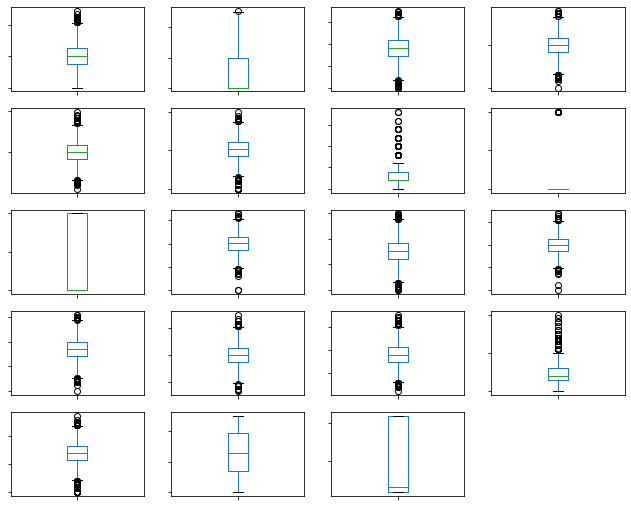


Histogram of each Numerical Feature


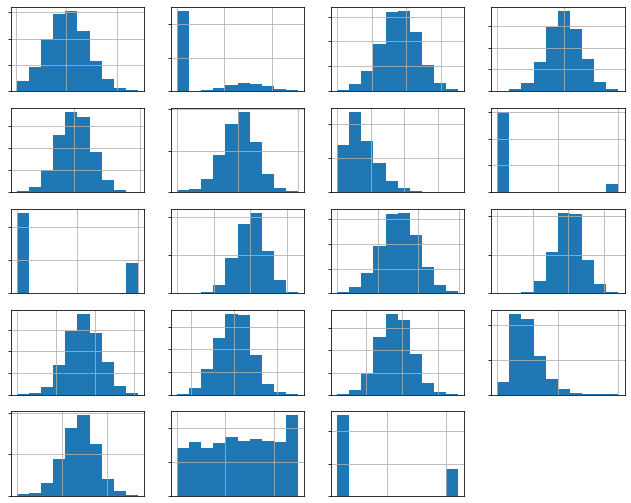


Correlation Matrix of All Numerical Features


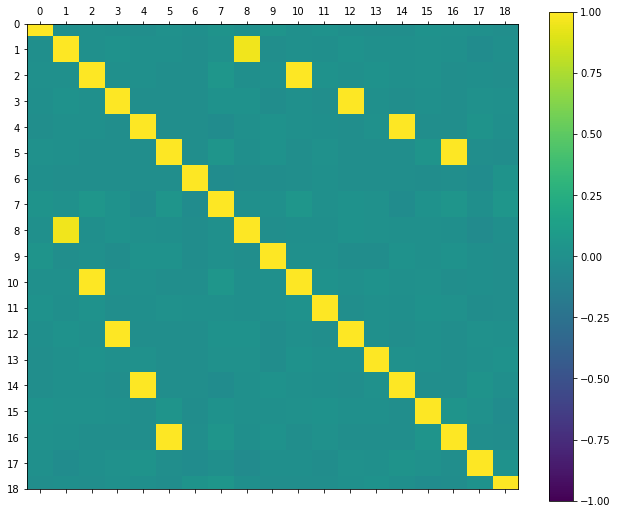


Correlation plot of Numerical features
                Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  \
Account_Length        1.00e+00      -4.63e-03  6.22e-03 -6.76e-03   -8.96e-03   
Vmail_Message        -4.63e-03       1.00e+00  7.78e-04  1.76e-02    7.68e-03   
Day_Mins              6.22e-03       7.78e-04  1.00e+00  7.04e-03    4.32e-03   
Eve_Mins             -6.76e-03       1.76e-02  7.04e-03  1.00e+00   -1.26e-02   
Night_Mins           -8.96e-03       7.68e-03  4.32e-03 -1.26e-02    1.00e+00   
Intl_Mins             9.51e-03       2.86e-03 -1.02e-02 -1.10e-02   -1.52e-02   
CustServ_Calls       -3.80e-03      -1.33e-02 -1.34e-02 -1.30e-02   -9.29e-03   
Intl_Plan             2.47e-02       8.75e-03  4.94e-02  1.91e-02   -2.89e-02   
Vmail_Plan            2.92e-03       9.57e-01 -1.68e-03  2.15e-02    6.08e-03   
Day_Calls             3.85e-02      -9.55e-03  6.75e-03 -2.15e-02    2.29e-02   
Day_Charge            6.21e-03       7.76e-04  1.00e+00  7.05e-03    

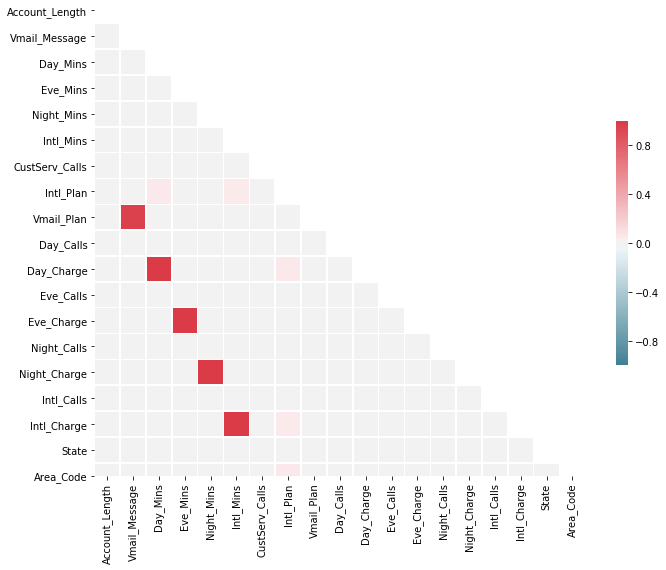


PIE Chart of for Target: 


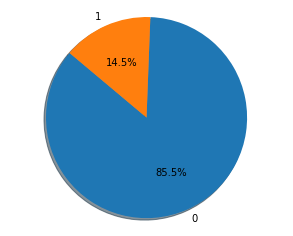

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  7.2min finished



 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

 The best score across ALL searched params:
 0.9543215405284371

 The best parameters across ALL searched params:
 {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 500}



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.4s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.4s finished



Cross Validation results:  [0.96888889 0.95982143 0.94618834 0.93721973 0.94170404 0.91928251
 0.96412556 0.96412556 0.96860987 0.97309417]
CV Mean Accuracy: 0.954306 (Std: 0.016543)


{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.2, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 8, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 500, 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


Evaluation of the trained model: 

Accuracy :  0.95

Kappa Score :  0.7884763303265505

Confusion Matrix :
 [[922  17]
 [ 38 123]]

Classification Report :
               precision    recall  f1-score   support

           0       0.96 

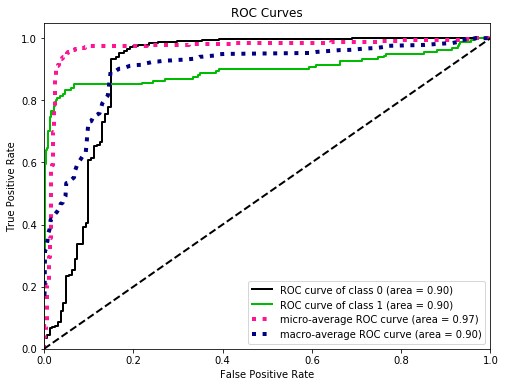

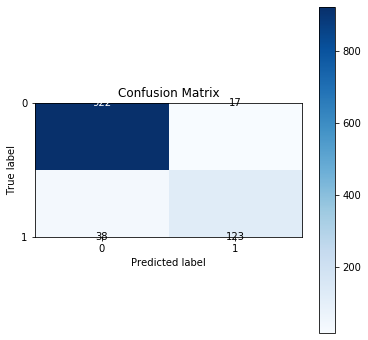

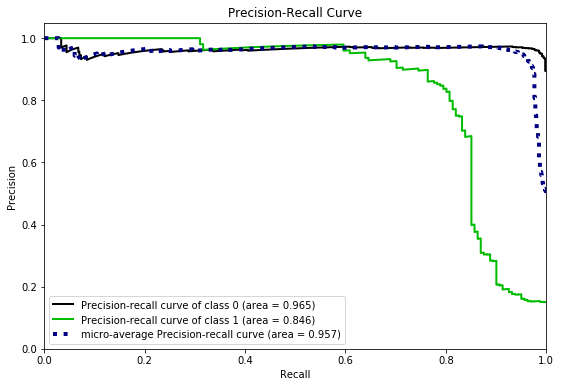


Feature Importance/Rank Analysis: 
1. feature 6 CustServ_Calls (0.181169)
2. feature 7 Intl_Plan (0.120360)
3. feature 2 Day_Mins (0.118003)
4. feature 1 Vmail_Message (0.100186)
5. feature 15 Intl_Calls (0.098751)
6. feature 5 Intl_Mins (0.079956)
7. feature 3 Eve_Mins (0.073988)
8. feature 4 Night_Mins (0.039833)
9. feature 17 State (0.036164)
10. feature 9 Day_Calls (0.033190)
11. feature 11 Eve_Calls (0.031731)
12. feature 13 Night_Calls (0.030688)
13. feature 0 Account_Length (0.030484)
14. feature 18 Area_Code (0.025499)
15. feature 8 Vmail_Plan (0.000000)
16. feature 10 Day_Charge (0.000000)
17. feature 12 Eve_Charge (0.000000)
18. feature 14 Night_Charge (0.000000)
19. feature 16 Intl_Charge (0.000000)


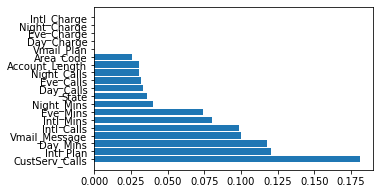

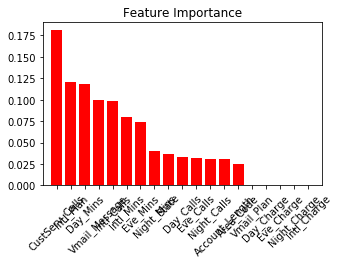

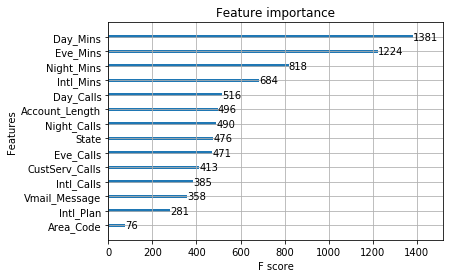

(3333, 21)
   Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  Intl_Mins  \
0             128             25     265.1     197.4       244.7       10.0   
1             107             26     161.6     195.5       254.4       13.7   
2             137              0     243.4     121.2       162.6       12.2   
3              84              0     299.4      61.9       196.9        6.6   
4              75              0     166.7     148.3       186.9       10.1   

   CustServ_Calls Churn Intl_Plan Vmail_Plan  ...  Day_Charge  Eve_Calls  \
0               1    no        no        yes  ...       45.07         99   
1               1    no        no        yes  ...       27.47        103   
2               0    no        no         no  ...       41.38        110   
3               2    no       yes         no  ...       50.90         88   
4               3    no       yes         no  ...       28.34        122   

   Eve_Charge  Night_Calls  Night_Charge  Intl_Calls  Int

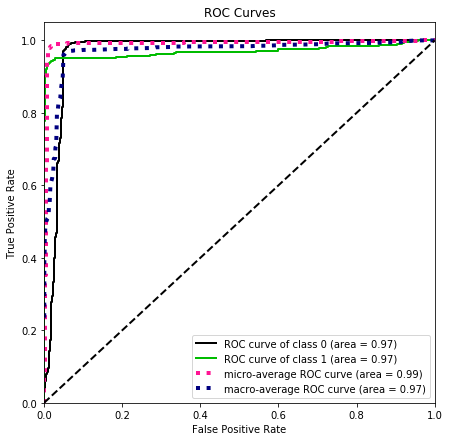

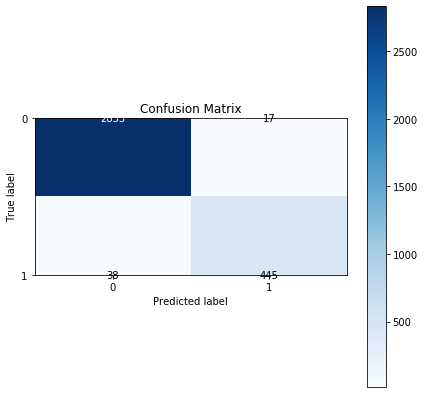

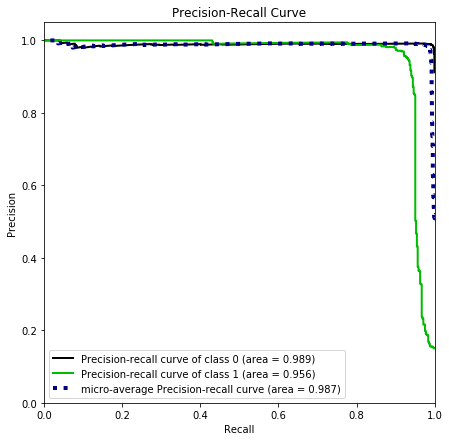


Execution Time 904.123881816864 seconds: 


In [20]:
    if __name__ == '__main__':
        print()
        print("Execution Time %s seconds: " % (start_time))
        filename = 'TelcoCustomerChurnDataset.csv'
        
        feature_names, target, dataset = load_dataset(filename)
        dataset = find_miising_value(feature_names, target, dataset)
        data_descriptiveStats(feature_names, target, dataset)
        data_visualization(feature_names, target, dataset)
        X_train, X_test, y_train, y_test = data_split(feature_names, target, dataset)
        model = training_model(X_train, y_train)
        model = cross_validatin_and_fitting(model, X_train, y_train)
        model = evaluate_model(model, X_test, y_test)
        featureRank_Analysis(model, dataset, feature_names)
        save_model(model) 
        
        test_filename = 'TelcoCustomerChurnDataset.csv'
        final_prediction(feature_names, test_filename)
        
        print()
        print("Execution Time %s seconds: " % (time.time() - start_time))

## References 

<ol>
    <li><a href="https://www.datacamp.com/community/tutorials/xgboost-in-python?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034358&utm_targetid=aud-299261629574:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1012859&gclid=Cj0KCQjwy8f6BRC7ARIsAPIXOjgHSEp4Fn6T5bASaSf06zgENmVPE-TnWHvzc76c2bWMV-kOWrkvARMaApx6EALw_wcB">Xgboost Classifier</a></li>
</ol>